In [274]:
import torch
import matplotlib.pyplot as plt

import math
from torch.nn.functional import conv1d
from torch.nn.functional import pad
from torch.autograd import grad

from utils import fft_conv

plt.rcParams.update({'font.size': 16})
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = [4, 2]

## Transfer Functions

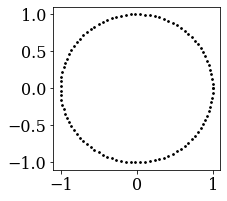

In [275]:
L = 100
w = torch.linspace(0, 2*torch.pi, L)
z = torch.exp(-1j * w)

plt.figure(figsize=(3, 3))
plt.scatter(z.real, z.imag, c='black', s=3)

A transfer function is a ratio of complex polynomials with real coefficients. Let us visualize
an example of a ratio of order 9, evaluated on the points above (roots of unity): 

In [276]:

# seed
torch.manual_seed(1234)

d = 4
num_poly_coefs = torch.randn(d) # a_0 z^{d-1} + a_1 z^{d-2} + ... + a_{d-1} z + a_d
den_poly_coefs = torch.randn(d)

# num_poly_coefs[0] = 1 # we fix a_0 = 1 to ensure that the polynomial is monic
# den_poly_coefs[0] = 1


def polyval(coefs, z):
    eval = coefs[0] + torch.zeros_like(z)
    for c in coefs[1:]:
        eval += eval * z + c
    return eval
    

In [277]:
num = polyval(num_poly_coefs, z)
den = polyval(den_poly_coefs, z)

H = num / den

Text(0.5, 1.0, 'transfer function')

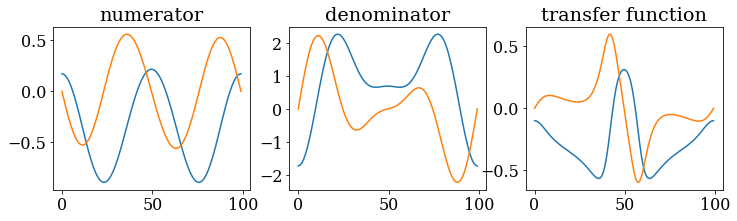

In [278]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
axs[0].plot(num.real)
axs[0].plot(num.imag)
axs[0].set_title('numerator')

axs[1].plot(den.real)
axs[1].plot(den.imag)
axs[1].set_title('denominator')

axs[2].plot(H.real)
axs[2].plot(H.imag)
axs[2].set_title('transfer function')

Note that the function is in general defined on the whole complex plane (other than some regions of "measure zero" where the denominator is zero):

In [279]:
x = torch.linspace(-3, 3, 200)
y = torch.linspace(-3, 3, 200)
X, Y = torch.meshgrid(x, y)
mesh = X + 1j * Y

In [280]:
num = polyval(num_poly_coefs, mesh)
den = polyval(den_poly_coefs, mesh)

H = num / den

H = H.reshape(200, 200)

Text(0.5, 0.92, 'imag part of num / den')

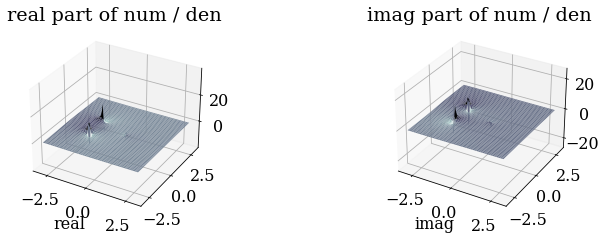

In [281]:
# 3d plot of the transfer function

fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(321, projection='3d')
ax.plot_surface(X, Y, H.real, cmap='bone_r')
ax.set_xlabel('real')
#ax.axis('off')
ax.set_title('real part of num / den')

ax = fig.add_subplot(322, projection='3d')
ax.plot_surface(X, Y, H.imag, cmap='bone_r')
ax.set_xlabel('imag')
#ax.axis('off')
ax.set_title('imag part of num / den')

The regions where $H(z) = \frac{Y(z)}{U(z)}$ is undefined (the "spiky" points in the visualizations above) are called the *poles* of the transfer function, and correspond to the roots of the 
polynomial at the denominator.

In [282]:
from numpy.polynomial.polynomial import polyroots

# this utility expects the polynomial coefficients to be in increasing order, i.e. a_0 z^0 + a_1 z^1 + ...
roots = polyroots(den_poly_coefs.flip(0).numpy()) - 1

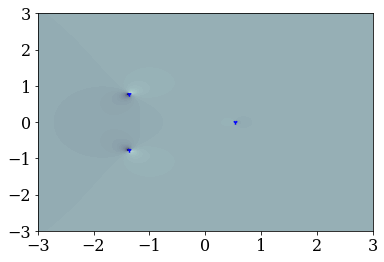

In [283]:
plt.figure(figsize=(6, 4))

plt.contourf(X, Y, H.real, cmap='bone_r', levels=100)
plt.scatter(roots.real, roots.imag, c='blue', marker="1", s=20)

As shown in the notes, transfer functions evaluated on the roots of unity correspond to the frequency response of a convolution filter. This nicely complements the FFT method of performing convolutions, which we have previously motivated by looking at circulant matrices. Let us see how to perform a convolution with kernel of length $L$ using an implicit transfer function representation:

In [284]:
L = M = 100
x = torch.linspace(0, 2*torch.pi, L)
freq = 5

u = torch.sin(freq * x)
u.requires_grad = True

# padding required for circular -> full convolution as shown in `fft_conv`
u_pad = pad(u, (0, M - 1))

# padding the kernel with zeros (might be tricky to see, check the notes)
w = torch.linspace(0, 2*torch.pi, 2*L - 1)
z = torch.exp(-1j * w)

num = polyval(num_poly_coefs, z)
den = polyval(den_poly_coefs, z)

H = num / den

U = torch.fft.fft(u_pad)
y = torch.fft.ifft(U * H)[:L]

Text(0.5, 1.0, 'output')

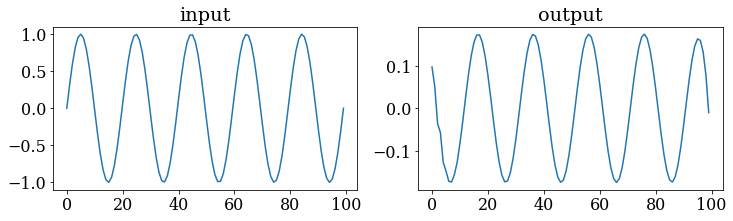

In [285]:
fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].plot(u.detach())
axs[0].set_title('input')

axs[1].plot(y.detach().real)
axs[1].set_title('output')

In this particular case, the input is a pure sine wave at a frequency $f$. It is not a coincidence that the outputs are also sinusoidal waves, as we will investigate in the next notebook.

Causality can be checked:

In [286]:
dydu = torch.zeros(L, L)
for n in range(L):
    dydu[n] = grad(y[n], u, retain_graph=True)[0]

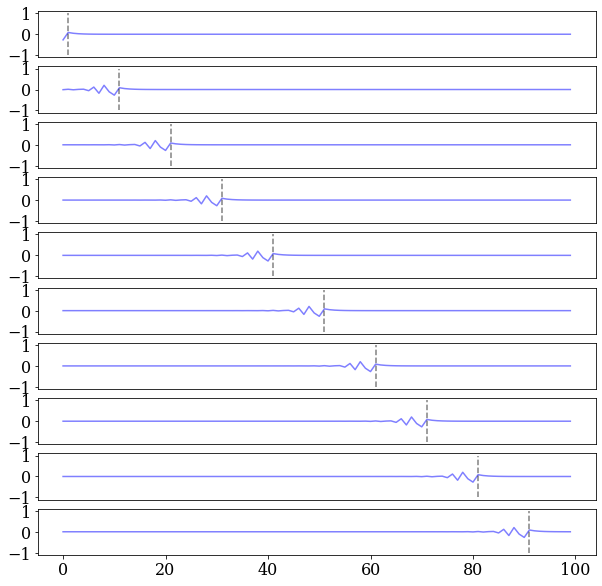

In [287]:
fig, axs = plt.subplots(10, 1, figsize=(10, 10))
for k in range(10): 
    axs[k].plot(dydu[10*k].detach(), c='blue', alpha=0.5)
    axs[k].vlines(10*k + 1, -1, 1, color='black', alpha=0.5, linestyle='--')
    if k < 9: axs[k].set_xticks([])

To summarize, transfer function implicit parametrizations for convolution kernels:

* Sidestep linear scaling $O(L)$ in the number of parameters for a length $L$ convolution
* Allow us to control and shape the kernel by an appropriate choice of polynomials and thus basis functions (similarly to state spaces)
* Can be evaluated directly in the frequency domain